<a href="https://colab.research.google.com/github/jkranyak/project_3/blob/second_model/Debug_SecondModel_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install tensorflow
!pip install isic-cli
!pip install kaggle
# !pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.5 MB/s eta 0:00:00


In [7]:
import os
# Specify the current path of kaggle.json file
current_path = '/content/kaggle.json'

# Desired path where the Kaggle API expects the kaggle.json file
desired_path = '/root/.kaggle/kaggle.json'

if os.path.exists(current_path):
    os.makedirs(os.path.dirname(desired_path), exist_ok=True)
    os.rename(current_path, desired_path)

    # Set the file's permissions to avoid a permissions error
    os.chmod(desired_path, 0o600)
else:
    print(f"Error: '{current_path}' does not exist. Please upload the file.")



In [6]:
! isic user login

visit the following url in a browser:
https://api.isic-archive.com/oauth/authorize?response_type=code&client_id=RpCzc4hFjv5gOJdM2DM2nBdokOviOh5ne63Tpn7Q&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=6ARyQbiQ7qg3qVFt8lvof77aPu0Q21&code_challenge=Bq0jVTWNiAjgt2O5Tggo3MGD7hndMJDOA5NKLl5OJtA&code_challenge_method=S256
enter the code shown in your browser: kOTYcoZQBr245uJlISeVL6K3iS9ESm
Success!


In [8]:
!kaggle datasets download -d andrewmvd/isic-2019


100% 9.08G/9.10G [01:58<00:00, 109MB/s]
100% 9.10G/9.10G [01:58<00:00, 82.5MB/s]


In [9]:
!unzip -q isic-2019.zip


In [10]:
!pip install scikit-learn

In [11]:
import numpy as np
import pandas as pd
import sklearn.utils.class_weight

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

https://www.nature.com/articles/s41598-021-96707-8

get the data over here

In [12]:
# Load the metadata
metadata = pd.read_csv('/content/ISIC_2019_Training_Metadata.csv')

# Display the first few rows of each DataFrame
metadata.head()


,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [13]:
metadata.shape

(25331, 5)

run all the same cells and augment by resampling the data like we did in model 1


In [14]:
ground_truth = pd.read_csv('/content/ISIC_2019_Training_GroundTruth.csv')
ground_truth

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
ground_truth['MEL'].value_counts()

MEL
0.0    20809
1.0     4522
Name: count, dtype: int64

In [16]:
ground_truth.shape

(25331, 10)

In [17]:
from pathlib import Path

ground_truth = pd.read_csv('/content/ISIC_2019_Training_GroundTruth.csv')
metadata = pd.read_csv('/content/ISIC_2019_Training_Metadata.csv')

image_dir = Path('/content/ISIC_2019_Training_Images')
ground_truth['image_path'] = ground_truth['image'].apply(lambda x: image_dir / f"{x}.jpg")

# Merge the ground_truth with metadata if necessary
full_metadata = pd.merge(ground_truth, metadata, on='image', how='left')  # Adjust 'on' parameter as needed
full_metadata

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_path,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,55.0,anterior torso,NaN,female
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,30.0,anterior torso,NaN,female
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,60.0,upper extremity,NaN,female
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,30.0,upper extremity,NaN,male
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,80.0,posterior torso,NaN,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007325...,55.0,palms/soles,BCN_0002083,female


In [18]:
# Display the image paths for the first few entries
print(full_metadata['image_path'].head())


0    /content/ISIC_2019_Training_Images/ISIC_000000...
1    /content/ISIC_2019_Training_Images/ISIC_000000...
2    /content/ISIC_2019_Training_Images/ISIC_000000...
3    /content/ISIC_2019_Training_Images/ISIC_000000...
4    /content/ISIC_2019_Training_Images/ISIC_000000...
Name: image_path, dtype: object


In [19]:
# Correct the base path in 'image_path' column
correct_base_path = "/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

full_metadata['image_path'] = full_metadata['image'].apply(lambda x: f"{correct_base_path}/{x}.jpg")

# Verify the correction by printing the first few entries again
print(full_metadata['image_path'].head())


0    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
1    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
2    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
3    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
Name: image_path, dtype: object


In [20]:
full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   MEL                  25331 non-null  float64
 2   NV                   25331 non-null  float64
 3   BCC                  25331 non-null  float64
 4   AK                   25331 non-null  float64
 5   BKL                  25331 non-null  float64
 6   DF                   25331 non-null  float64
 7   VASC                 25331 non-null  float64
 8   SCC                  25331 non-null  float64
 9   UNK                  25331 non-null  float64
 10  image_path           25331 non-null  object 
 11  age_approx           24894 non-null  float64
 12  anatom_site_general  22700 non-null  object 
 13  lesion_id            23247 non-null  object 
 14  sex                  24947 non-null  object 
dtypes: float64(10), object(5)
memory usa

In [21]:
# Fill missing values for 'age_approx' with its median
full_metadata['age_approx'].fillna(full_metadata['age_approx'].median(), inplace=True)

# For categorical data, fill missing values with 'unknown'
full_metadata['anatom_site_general'].fillna('unknown', inplace=True)
full_metadata['sex'].fillna('unknown', inplace=True)


In [22]:
full_metadata = pd.get_dummies(full_metadata, columns=['anatom_site_general', 'sex'])


In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Let's separate features and labels first
X = full_metadata.drop(['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], axis=1)
y = full_metadata[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']]  # Excluded 'UNK'

# Now, we split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the number of samples per class
class_counts = y_train.sum().sort_values(ascending=False)
print("Class counts before resampling:\n",class_counts)

# Find the maximum number of samples in any single class
max_samples = class_counts.max()




Class counts before resampling:
 NV      10308.0
MEL      3607.0
BCC      2665.0
BKL      2088.0
AK        690.0
SCC       524.0
DF        191.0
VASC      191.0
dtype: float64


In [24]:
# Split the X_temp and y_temp further into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Calculate the target number of samples
target_samples = int((3607 + 10308) / 2)  # adjust this as needed

# Create new DataFrame for the balanced dataset
X_train_resampled = pd.DataFrame(columns=X_train.columns)
y_train_resampled = pd.DataFrame(columns=y_train.columns)

# Iterate through each class and apply resampling
for column in y_train.columns:
    # Filter samples for the current class
    filter_mask = y_train[column] == 1
    X_class = X_train[filter_mask]
    y_class = y_train[filter_mask]

    num_samples = len(X_class)
    if num_samples > 0:
        if num_samples < target_samples:
            # Oversample minority classes
            X_class_resampled, y_class_resampled = resample(X_class, y_class,
                                                            replace=True,  # Sample with replacement
                                                            n_samples=target_samples,  # Match the target samples
                                                            random_state=42)
        else:
            # For majority or adequately represented classes, we might undersample or keep as is
            X_class_resampled, y_class_resampled = resample(X_class, y_class,
                                                            replace=False,
                                                            n_samples=target_samples,
                                                            random_state=42)

        # Append resampled data back to the overall dataset
        X_train_resampled = pd.concat([X_train_resampled, X_class_resampled], axis=0)
        y_train_resampled = pd.concat([y_train_resampled, y_class_resampled], axis=0)
    else:
        print(f"No instances to resample for class '{column}'")

# Shuffle the dataset to mix up class order (important for training)
X_train_resampled = X_train_resampled.sample(frac=1, random_state=42)
y_train_resampled = y_train_resampled.loc[X_train_resampled.index]

print("New class counts after resampling:\n", y_train_resampled.sum())


New class counts after resampling:
 MEL      20651.0
NV        6957.0
BCC      25309.0
AK       77387.0
BKL      30227.0
DF      261561.0
VASC    261561.0
SCC      99679.0
dtype: float64


In [25]:
# Concatenate multiple columns into a single 'labels' column
#full_metadata['labels'] = full_metadata[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']].idxmax(axis=1)
# Creating a single 'labels' column
class_columns = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']  # Adjust if there are different/more classes
full_metadata['labels'] = (full_metadata[class_columns] == 1).idxmax(1)
full_metadata['labels']

0         NV
1         NV
2        MEL
3         NV
4        MEL
        ... 
25326    BCC
25327    BKL
25328    MEL
25329     NV
25330    BKL
Name: labels, Length: 25331, dtype: object

In [26]:

full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   image                                25331 non-null  object 
 1   MEL                                  25331 non-null  float64
 2   NV                                   25331 non-null  float64
 3   BCC                                  25331 non-null  float64
 4   AK                                   25331 non-null  float64
 5   BKL                                  25331 non-null  float64
 6   DF                                   25331 non-null  float64
 7   VASC                                 25331 non-null  float64
 8   SCC                                  25331 non-null  float64
 9   UNK                                  25331 non-null  float64
 10  image_path                           25331 non-null  object 
 11  age_approx                  

then run this model and lets see how it compares to our model

In [27]:
import numpy as np
import pandas as pd
import sklearn.utils.class_weight

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'full_metadata' is already defined and loaded as shown previously
# full_metadata['labels']
# Splitting the data into training, validation, and test sets
train_val_data, test_data = train_test_split(full_metadata, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

# print(train_val_data.info())

# print(train_data.info())

import os

# Sample 15 rows from your DataFrame
sample_data = train_data.sample(n=15, random_state=42)

# Iterate over each row in the sample and test the file path
for index, row in sample_data.iterrows():
    image_path = row['image_path']
    if os.path.exists(image_path):
        print(f"Image file exists: {image_path}")
    else:
        print(f"Image file not found: {image_path}")

# Prepare ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Setup generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=None,
    x_col='image_path',
    y_col='labels',  # Ensure your labels column is correctly named and formatted
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

print(len(train_generator))
if train_generator is None:
    raise ValueError("`train_generator` is not defined.")
# print(train_generator.y_col)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=None,
    x_col='image_path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)



Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0061263.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0028258.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0028262.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0068778.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0068337.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0024533.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0063268.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0024875.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0029079.jpg
Image file exists: /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0056957.jpg
Image file exists: /content/ISIC_2019_Training_Inp

In [ ]:
import sklearn.utils as sku
# print(sku.compute_class_weight.__doc__)

In [ ]:
from sklearn.utils import compute_class_weight

# Calculate class weights for handling class imbalance
labels = train_data['labels'].values  # Make sure this reflects your actual labels
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
# class_weights = compute_class_weight('balanced', np.unique(labels), labels)
class_weights = dict(enumerate(class_weights))

# class_weights = compute_class_weight('balanced', np.unique(labels), labels)
labels_index = {label: index for index, label in enumerate(np.unique(labels))}
class_weights = {labels_index[label]: len(labels) / class_count
                 for label, class_count in zip(np.unique(labels), np.bincount([labels_index[label] for label in labels]))}
print(class_weights)
# Load DenseNet169
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ...
# Load DenseNet169
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(np.unique(labels)), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (to be defined based on your specific needs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ready to train
history = model.fit(train_generator, epochs=10, validation_data=val_generator, class_weight=class_weights)


In [ ]:
# Evaluate the model on the test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=None,
    x_col='image_path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Make sure not to shuffle the test data
)

print(len(test_generator))
if test_generator is None:
    raise ValueError("`test_generator` is not defined.")

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Save the trained model
# model.save("trained_model.h5")



# Model Interpretation (example: visualize feature importance)
# Code for interpretation goes here

# Ensemble Methods (example: stacking multiple models)
# Code for ensemble methods goes here

# Deployment (example: saving the model for deployment)
model.save("final_model.h5")

# Continuous Monitoring (example: monitoring model performance)
# Code for continuous monitoring goes here

# Feedback Loop (example: collect feedback and retrain model)
# Code for feedback loop goes here

# Documentation and Reporting
# Document your model architecture, training process, and results
# Write a report summarizing your findings and conclusions


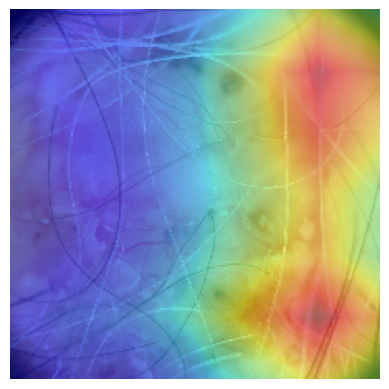

In [31]:
# Model Interpretation (example: visualize feature importance)
# Code for interpretation goes here
!pip install tf-keras-vis

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tf_keras_vis.gradcam import GradcamPlusPlus
from tf_keras_vis.utils import normalize

# Define a function to generate the Grad-CAM visualization
def generate_gradcam(model, img_array, layer_name):
    # Initialize GradCAM++ object
    gradcam = GradcamPlusPlus(model, model_modifier=None)

    # Define the loss function for Grad-CAM
    def loss(output):
        return tf.keras.backend.mean(output[:, tf.argmax(output[0])])

    # Generate Grad-CAM heatmap
    cam = gradcam(loss, img_array, penultimate_layer=layer_name)
    cam = normalize(cam)

    return cam


# Choose an image from the new data for visualization
# img_path = 'new_data_directory/image.jpg'
img_path ='/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0057266.jpg'

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Choose a layer for visualization (e.g., the last convolutional layer before the GlobalAveragePooling2D layer)
layer_name = 'conv5_block32_concat'

# Generate Grad-CAM visualization
cam = generate_gradcam(model, img_array, layer_name)

# Overlay the heatmap on the original image
plt.imshow(img)
plt.imshow(cam[0], cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()


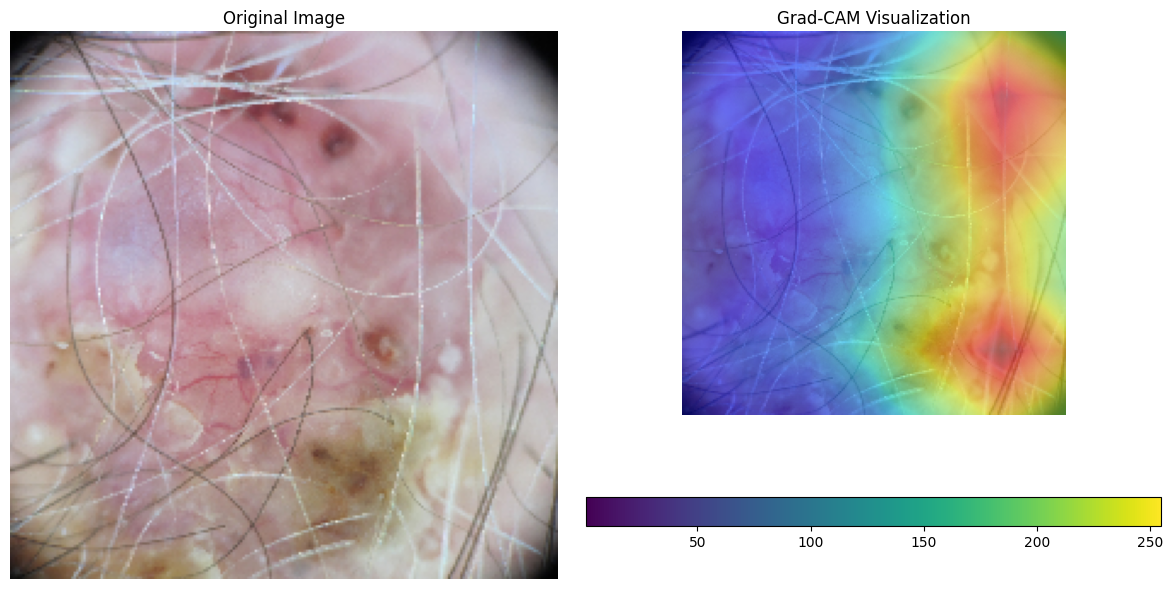

In [32]:

# Load the original image
original_img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))

# Generate Grad-CAM visualization
cam = generate_gradcam(model, img_array, layer_name)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axs[0].imshow(original_img)
axs[0].set_title('Original Image')
axs[0].axis('off')

# Plot the Grad-CAM heatmap overlaid on the original image
heatmap = axs[1].imshow(original_img)
axs[1].imshow(cam[0], cmap='jet', alpha=0.5)
axs[1].set_title('Grad-CAM Visualization')
axs[1].axis('off')

# Add colorbar for the heatmap
plt.colorbar(heatmap, ax=axs[1], orientation='horizontal')

# Show the figure
plt.tight_layout()
plt.show()
